In [2]:
!pip install -q fastai
!pip install -q nbdev
!pip install -q graphviz

# Get the dataset

In [3]:
import os

# Get Azure Bing Image Search key
key = os.environ.get('AZURE_SEARCH_KEY', '9f86584a506d402c902e2b82eca8385f')

In [5]:
from utils import search_images_bing

results = search_images_bing(key, 'ragdoll cat')   # Returns L
ims = results.attrgot('contentUrl')
len(ims)

149

Let's check one of the images to confirm it is relevant.

In [6]:
from fastdownload import download_url

dest = 'images/ragdoll.jpg'
download_url(ims[0], dest)

Path('images/ragdoll.jpg')

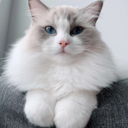

In [7]:
from PIL import Image

im = Image.open(dest)
im.to_thumb(128, 128)

It seems good. Let's download all the URLs for each images.

In [21]:
from pathlib import Path

cat_types = 'ragdoll', 'siamese', 'turkish angora'
path = Path('cats')

In [23]:
from fastai.vision.utils import download_images

if not path.exists():
    path.mkdir()
    
for o in cat_types:
    dest = path/o
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} cat')
    download_images(dest, urls=results.attrgot('contentUrl'))

Check if the download has been done well.

In [28]:
from fastai.data.transforms import get_image_files

fns = get_image_files(path)
fns

(#406) [Path('cats/ragdoll/0ab12576-ab3a-4de3-8e72-47d539fe3fa6.jpg'),Path('cats/ragdoll/0cea31c4-074e-4208-9f41-eb3f2585c015.jpg'),Path('cats/ragdoll/0d492077-da14-4a6c-ac45-8a2e14595c60.jpeg'),Path('cats/ragdoll/0dec9967-c0bf-4885-9417-196181642d5d.jpg'),Path('cats/ragdoll/1007593e-bb66-4dd8-b155-569c50408cac.jpg'),Path('cats/ragdoll/1106a616-ab73-4ae2-a55f-212b034ba67e.jpg'),Path('cats/ragdoll/12156a0d-dc3f-4270-b102-6d7f42994384.jpg'),Path('cats/ragdoll/123f173a-5f19-41c0-9d07-6a98b75e2e97.png'),Path('cats/ragdoll/1278e9f5-d136-499a-8942-7d4a2a1e7902.jpg'),Path('cats/ragdoll/12af0214-b00e-4fe6-8c7f-62c61ef2796e.jpg'),Path('cats/ragdoll/1337b37d-396a-47d2-96f9-ea4ea524d7a1.jpg'),Path('cats/ragdoll/17365be9-da66-46f4-b799-a61ce3d2871c.jpg'),Path('cats/ragdoll/1812b979-4869-466a-9421-3b7a7c9fdc46.jpg'),Path('cats/ragdoll/188f4bfc-295a-4247-bca1-ef821841b2bf.jpg'),Path('cats/ragdoll/1939c052-04c6-4a81-98fe-ea9c265f1741.jpg'),Path('cats/ragdoll/1d0710ea-8a90-4896-a25e-ada1ffd2820b.jpg')

There could be corrupt(cannot be opened) file. Let's check and remove those.

In [30]:
from fastai.vision.utils import verify_images

failed = verify_images(fns)
failed

(#7) [Path('cats/ragdoll/1337b37d-396a-47d2-96f9-ea4ea524d7a1.jpg'),Path('cats/ragdoll/8814578b-5b47-4a48-9a43-0cfd7e64face.jpg'),Path('cats/siamese/25fde5a7-2529-4179-a951-0064369e9f25.jpg'),Path('cats/siamese/4f58311c-4367-40d1-a690-350c916eff33.jpg'),Path('cats/siamese/65a0d396-6732-48e6-93d7-668227be5749.jpg'),Path('cats/siamese/78d7a0a7-38e6-490c-97f3-83ace421e11e.jpg'),Path('cats/turkish angora/31c779c7-f511-4bd1-a98f-e81950af794f.jpg')]

In [35]:
# Remove the failed pathes
failed.map(Path.unlink)

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다: 'cats\\ragdoll\\1337b37d-396a-47d2-96f9-ea4ea524d7a1.jpg'

In [278]:
?failed.map

# Data Preparation

## Image Transformation

`DataBlock` is flexible and fully customisable object to create a dataloader

In [86]:
from fastai.vision.all import *

# DataBlock is to set the configuration
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    item_tfms=Resize(128),   # Resize crops the image by default
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)
# dataloaders to get the data source
dls = db.dataloaders(path)

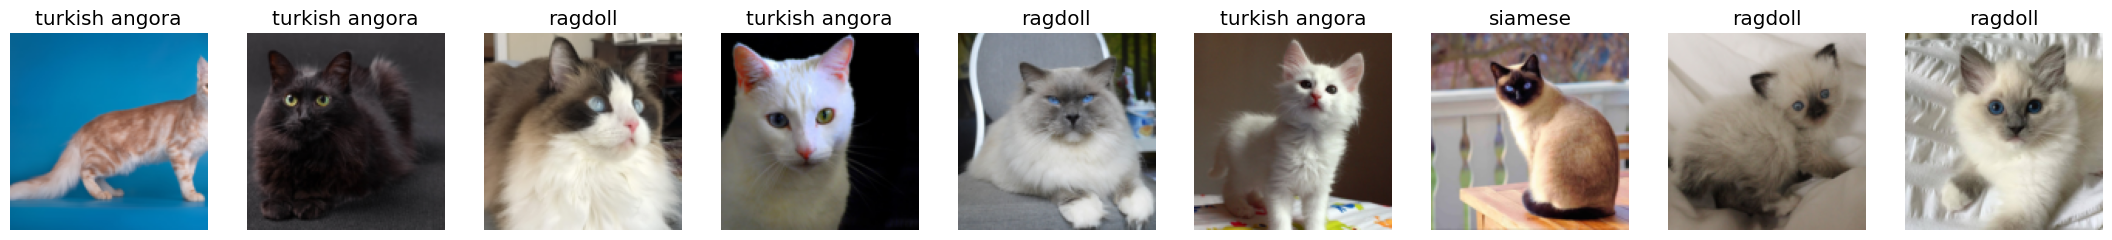

In [87]:
# See a batch (64 by default) of data provided by dataloader to GPU.
dls.show_batch(max_n=9, nrows=1)

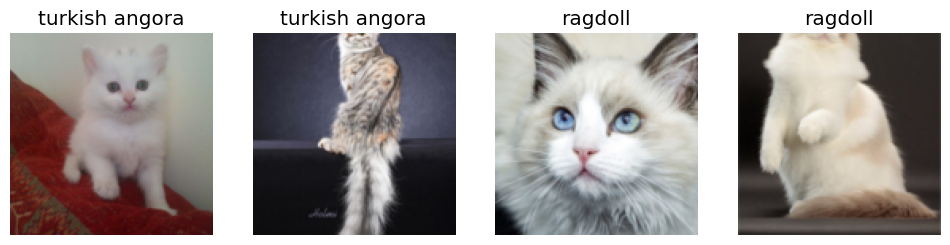

In [88]:
dls.train.show_batch(max_n=4, nrows=1)

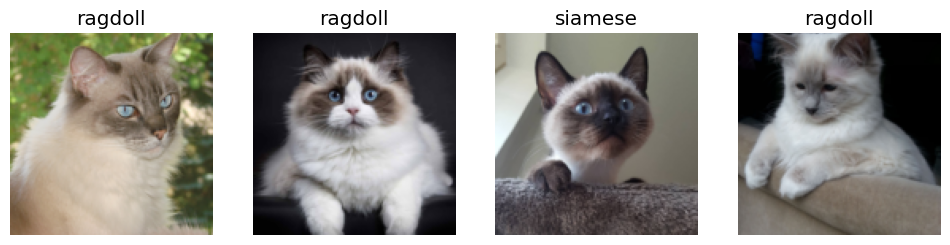

In [89]:
dls.valid.show_batch(max_n=4, nrows=1)

Not to crop the images but to pad or stretch for keeping all information, `Resize` can be adjusted.

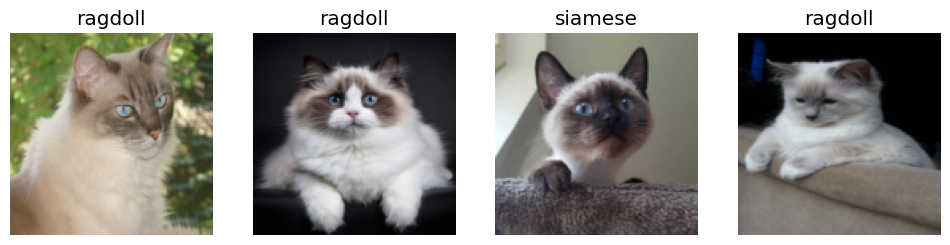

In [90]:
# Create a new DataBlock with other item_tfms to squish the images
db = db.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = db.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

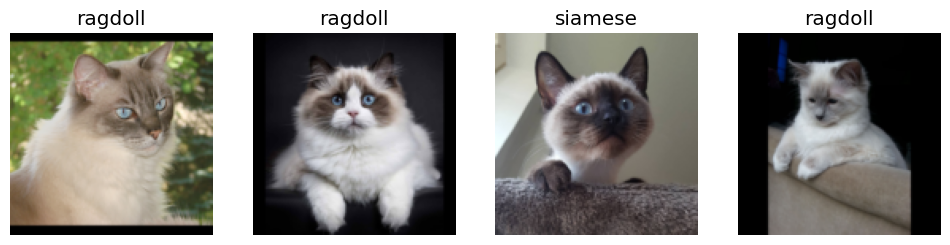

In [92]:
# Alternatively to pad the images
db = db.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = db.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Cropping, Squishing and padding all have problems of not reflecting the real image properly. Cropping can cut the important feature out; squishing torture the images to unrealistic ones; padding has a lot of empty spaces with zeros that the model cannot learn from and wastes computation.

Instead, in practice, randomly select and crop some part of image for each epoch. Let's implement the idea.

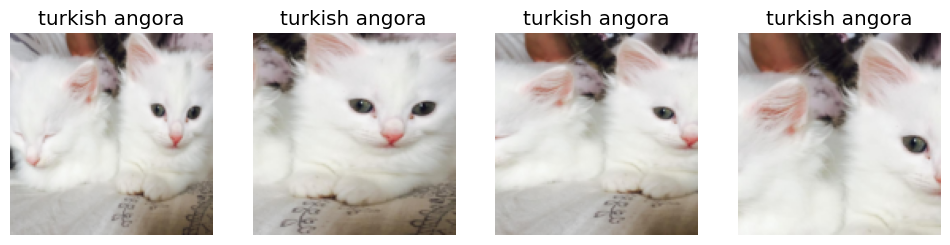

In [101]:
db = db.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = db.dataloaders(path)
# 'unique' do this process on a picture
dls.train.show_batch(max_n=4, nrows=1, unique=True)

This process is generally called as Data Augmentation.

## Data Augmentation

In the code below, `Resize` is applied to both train and valid set, while `aug_transforms` only to train set.

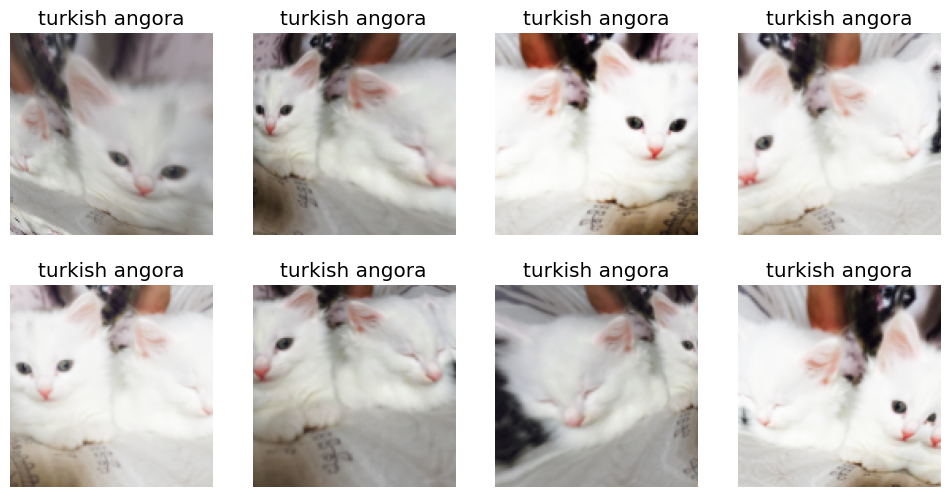

In [127]:
# In this setting, different types of augmentation happen according to probability in a batch
db = db.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = db.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Model Training

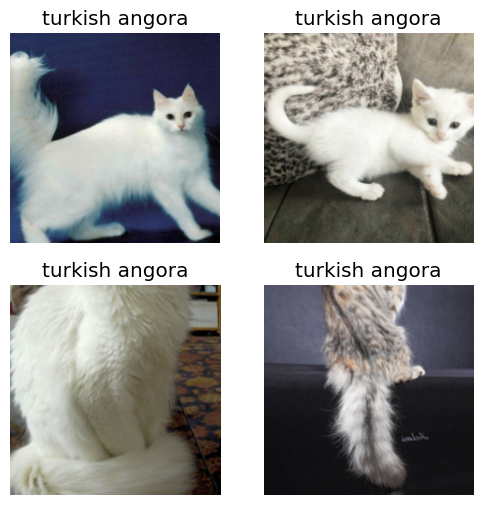

In [312]:
db = db.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = db.dataloaders(path)
dls.show_batch(max_n=4)

In [244]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Check the lossess in detail.

In [246]:
# Train losses: 320 training data divided into 5 batches, run for 4 epochs
learn.recorder.losses

[TensorBase(0.8389),
 TensorBase(0.6687),
 TensorBase(0.6045),
 TensorBase(0.6340),
 TensorBase(0.5862),
 TensorBase(0.5873),
 TensorBase(0.5492),
 TensorBase(0.5359),
 TensorBase(0.5089),
 TensorBase(0.4651),
 TensorBase(0.4464),
 TensorBase(0.4241),
 TensorBase(0.4048),
 TensorBase(0.3972),
 TensorBase(0.3771),
 TensorBase(0.3590),
 TensorBase(0.3404),
 TensorBase(0.3244),
 TensorBase(0.3068),
 TensorBase(0.2973)]

In [247]:
# Validation losses
learn.recorder.values

[(#3) [0.5861996412277222,0.23120416700839996,0.050632912665605545],
 (#3) [0.4650686979293823,0.21403580904006958,0.06329113990068436],
 (#3) [0.377063125371933,0.2391269952058792,0.06329113990068436],
 (#3) [0.2972913086414337,0.2483409196138382,0.07594936341047287]]

See the validation results in confusion matrix.

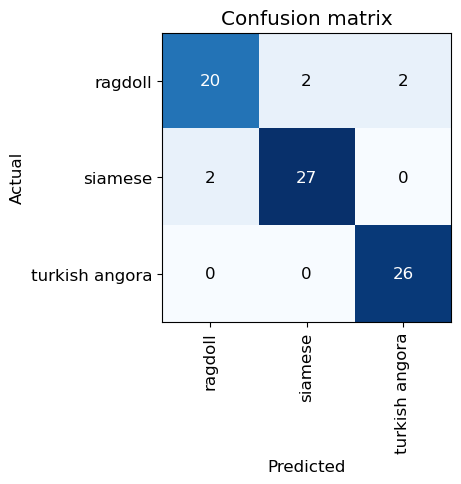

In [249]:
# 'from_learner' method has @classmethod decorator.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [251]:
learn.recorder.values  # why the values changes?

[(#2) [0.2483409196138382,0.07594936341047287]]

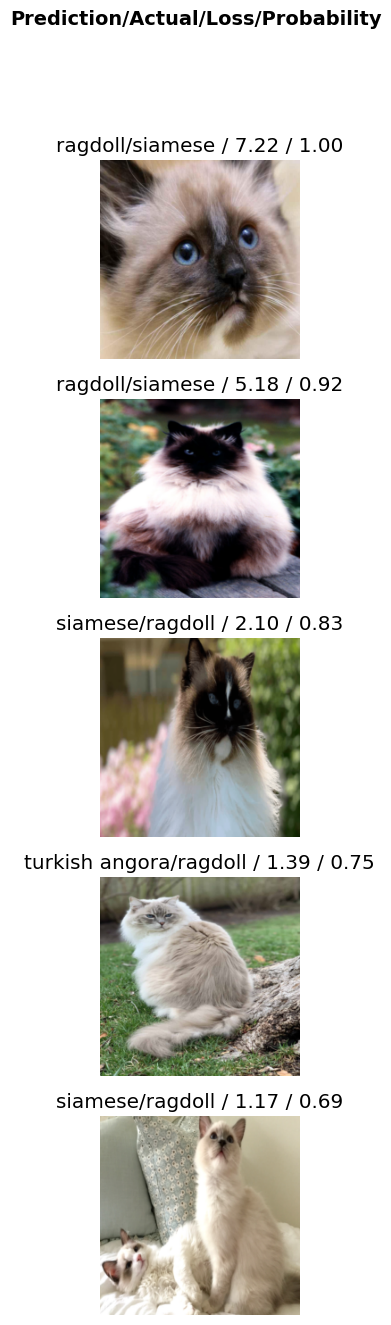

In [252]:
interp.plot_top_losses(5, nrows=5)

Like the examples above, incorrect classification could be because irrelevant images are included in dataset, or the labeling is wrong. Irrelevant images that don't fall into any of the categories should be removed, and the wrong labeling should be corrected before training in the cleaining process. However, training a model without it still helps to identify the cases. `fastai` has a GUI to facilitate this process.

In [263]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\SK\\Desktop\\fastai\\Lesson02\\cats\\siamese\\b00709a5-a7f2-45a2-8230-d39e5f8f5f2e.jpg'

This is just to decide and memorise which ones to be deleted or re-classified. The codes to put those decision in action are below. 

Note that these methods are only applied in the current view; whenever after selecting what to delete or change in a category from train or valid set, these methods should be run before moving to the other view.

In [311]:
# Remove the indices of deletion
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
    
# Move incorrect images to the right folder
for idx, cat in cleaner.change():
    shutil.move(cleaner.fns[idx], path/cat)

Now that we have cleaned dataset, we can train the model again and see how the performance changes.

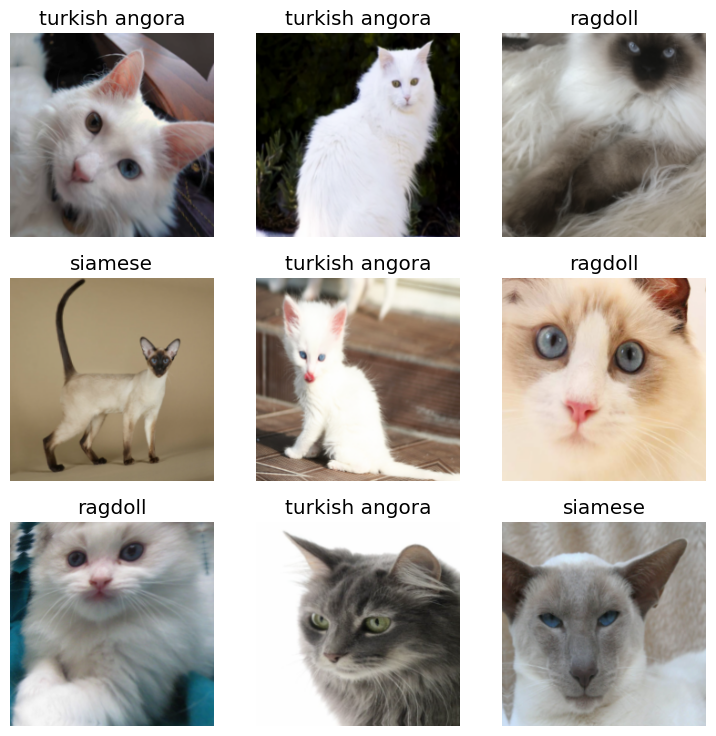

In [314]:
dls = db.dataloaders(path)
dls.show_batch()

In [315]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

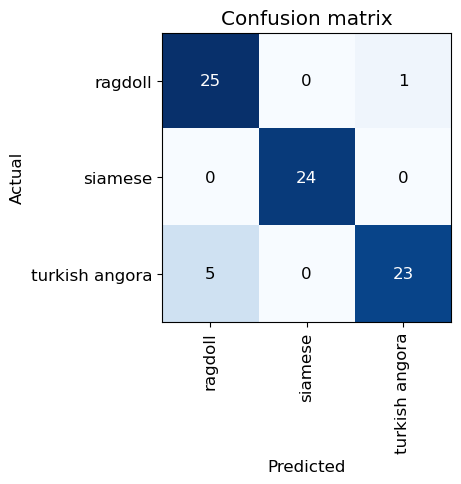

In [316]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Inference

In [322]:
# Save the fined tuned model first.
learn.export()

We have the model already in this notebook, we will mimic the process of loading the saved model for inference.

In [324]:
# Check the file name
path = Path()    # Current path
path.ls(file_exts='.pkl')   # Get the exported file path

(#1) [Path('export.pkl')]

In [326]:
# Load the saved model
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/turkish.jpg')

('turkish angora', tensor(2), tensor([0.0019, 0.0739, 0.9242]))

It infers the category of image correctly. If not sure about the order of categories in the probabilities, check the vocabulary of the dataloaders.

In [330]:
# Collection of categories
learn_inf.dls.vocab

['ragdoll', 'siamese', 'turkish angora']

# Create a Notebook App

   This requires two packages, `Ipython Widgets` and `Voila`.
   * `Ipython Widgets`: makes an app inside Jupyter notebook.
   * `Voila`: converts the web application written in notebook to an web application. Users don't need to use Jupyter to access the app.

In [333]:
!pip install ipywidgets voila

  Obtaining dependency information for voila from https://files.pythonhosted.org/packages/7a/fc/ebc74e04619f84200df9ab029be6aeeab6ae3b82ec3e97c177d83839383d/voila-0.5.8-py3-none-any.whl.metadata
  Obtaining dependency information for websockets>=9.0 from https://files.pythonhosted.org/packages/11/25/bb8f81a4ec94f595adb845608c5ec9549cb6b446945b292fe61807c7c95b/websockets-14.1-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/4.5 MB ? eta -:--:--
   - -------------------------------------- 0.2/4.5 MB 3.9 MB/s eta 0:00:02
   --- ------------------------------------ 0.4/4.5 MB 4.4 MB/s eta 0:00:01
   ----- ---------------------------------- 0.6/4.5 MB 4.3 MB/s eta 0:00:01
   ------- -------------------------------- 0.8/4.5 MB 4.3 MB/s eta 0:00:01
   --------- ------------------------------ 1.0/4.5 MB 4.4 MB/s eta 0:00:01
   ---------- ----------------------------- 1.2/4.5 MB 4.6 MB/s eta 0:00:01
   ------------ --------------------------- 1.4/4.5 MB 4.5 MB/s 

In [400]:
import ipywidgets as widgets

# File upload widget
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

In [512]:
# To see the uploaded image
img = widgets.Image(
            value=btn_upload.value[0].content.tobytes(), 
            height=128, width=128
      )

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img)
out_pl

Output()

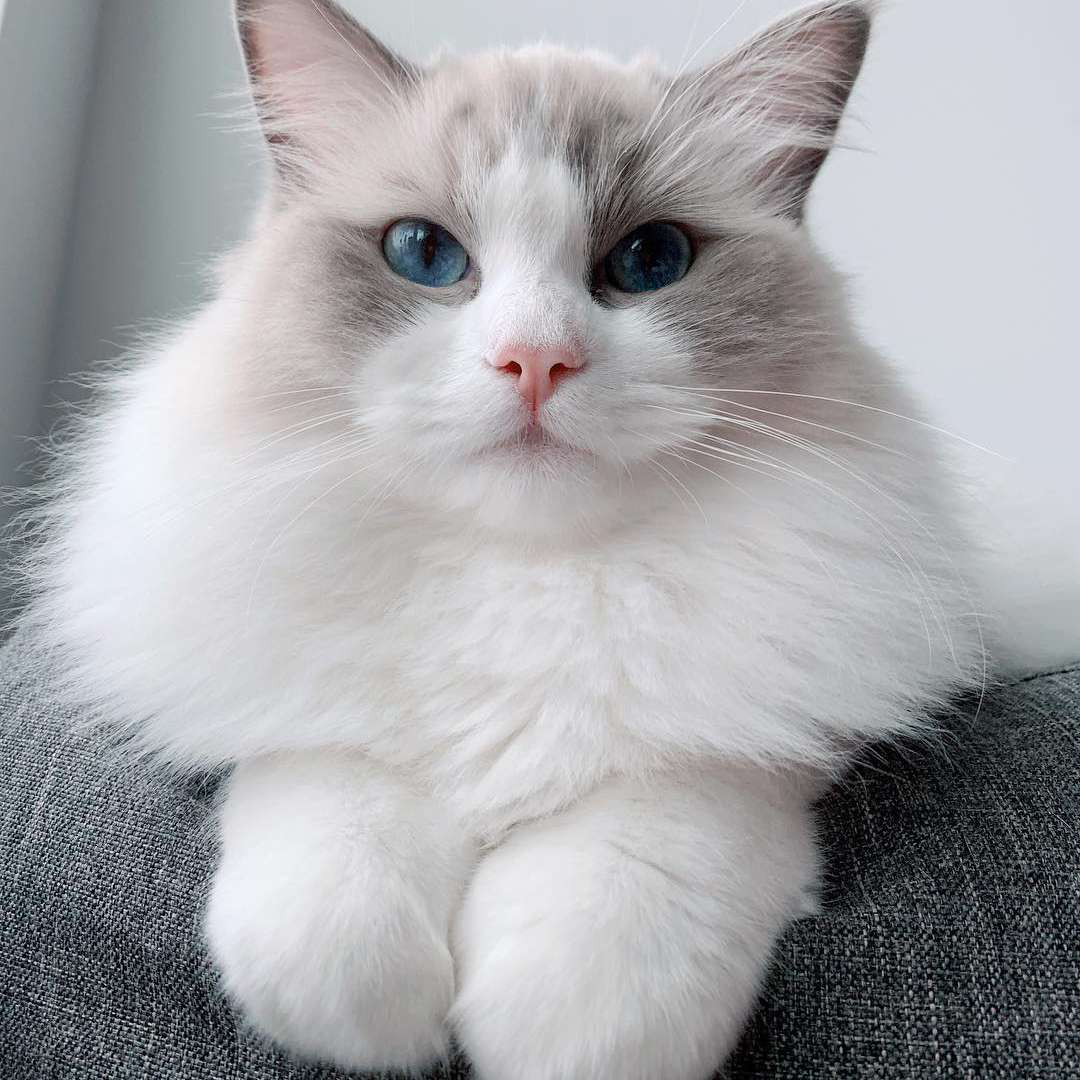

In [641]:
# Alternatively, to fake the button clicking to upload
btn_upload_f = SimpleNamespace(data=['images/ragdoll.jpg'])
img = PILImage.create(btn_upload_f.data[-1])
img

In [422]:
# To display the selected imgage
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img.to_thumb(128, 128))
out_pl

Output()

In [428]:
# Predict on the image
# To use the uploaded image for prediction, it should be converted to bytes format
pred, pred_idx, probs = learn_inf.predict(btn_upload.value[0].content.tobytes())

In [638]:
# Display the results
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}, Probability: {probs[pred_idx]:.4f}'
lbl_pred

Label(value='Prediction: ragdoll, Probability: 0.9781', layout=Layout(width='300%'))

Note that when the button `btn_run` is clicked with the `on_click` function below, the result appears under the cell where the last `out_pl` is implemented. If the function doesn't have `out_pl`, it will be displayed under the button.

In [542]:
# Button to do the prediction
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [586]:
# Click event handler - copy the codes above
def on_click_classify(change):
    out_pl.clear_output()
    img_bytes = btn_upload.value[0].content.tobytes()
    # Display the image with predicted label
    with out_pl:
        display(widgets.Image(value=img_bytes, height=128, width=128))
        pred, pred_idx, probs = learn_inf.predict(img_bytes)
        lbl_pred.value = f'Prediction: {pred}, Probability: {probs[pred_idx]:.4f}'
        display(lbl_pred)
    
btn_run.on_click(on_click_classify)   

Now, we ssemble all the code to build GUI using `VBox` (vertical box).

In [639]:
widgets.VBox([
    widgets.Label('Select your cat pic!'),
    btn_upload,
    btn_run,
    out_pl
], layout=widgets.Layout(width='300%'))

The widget displays a bit clipped label, but it works fine in the web app. To build the app, only the neccessary codes should be moved in another notebook. Voila will make an app out of markdown and code output, so unnecessary markdown should be removed. The app file is 'App.ipynb'.